# Chapter 5 - Dermatologist Project

A Transfer Learning project to classify images of skin lesions into melanoma, nevus and seborrheic keratosis using [ResNet50](https://arxiv.org/abs/1512.03385) model pretrained on [ImageNet](http://www.image-net.org/).

## Loading the dataset

We load the training, validation and testing sets and resize the images to 224×224. Then, we preprocess the images for ResNet50.

In [1]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets

Using TensorFlow backend.


In [2]:
# load train, test, and validation datasets

train_files, train_targets = load_dataset('data/train')
valid_files, valid_targets = load_dataset('data/valid')
test_files, test_targets = load_dataset('data/test')

In [3]:
from os import listdir

diseases = sorted(listdir('data/train'))

print('There are {} classes: {}.'.format(len(diseases), ', '.join(diseases)))
print('There are {} training images.'.format(len(train_files)))
print('There are {} validation images.'.format(len(valid_files)))
print('There are {} testing images.'.format(len(test_files)))

There are 3 classes: melanoma, nevus, seborrheic_keratosis.
There are 2000 training images.
There are 150 validation images.
There are 600 testing images.


### Visualize the first 12 training images

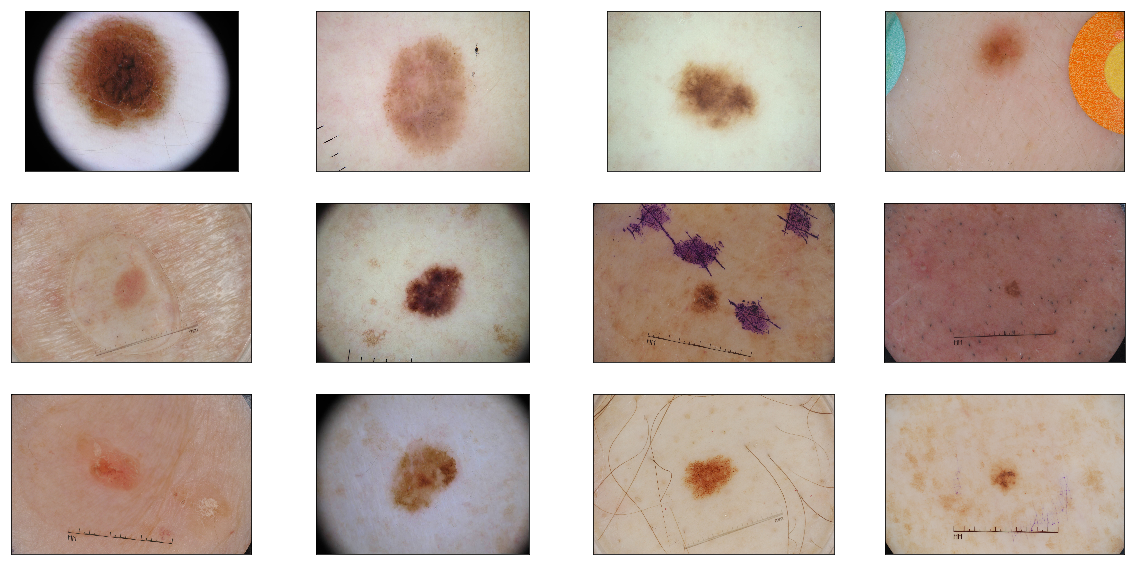

In [4]:
# Visualize what the data looks like
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_img(img_path, ax):
    img = cv2.imread(img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(20 ,10))
for i in range(12):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    visualize_img(train_files[i], ax)

# Date Pre-processing

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where nb_samples corresponds to the total number of images (or samples), and rows, columns, and channels correspond to the number of rows, columns, and channels for each image, respectively.

The path_to_tensor function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN. The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels. Next, the image is converted to an array, which is then resized to a 4D tensor. In this case, since we are working with color images, each image has three channels. Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The **paths_to_tensor** function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, nb_samples is the number of samples, or number of images, in the supplied array of image paths. It is best to think of nb_samples as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [6]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

print("Shape of the tensor:")
print(path_to_tensor(train_files[0]).shape)

Shape of the tensor:
(1, 224, 224, 3)


In [7]:
# from keras.preprocessing import image
# from tqdm import tqdm_notebook

# def get_tensor(path):
#     img = image.load_img(path, target_size=(224, 224))
#     return np.expand_dims(image.img_to_array(img), axis=0)

# def get_tensors(paths):
#     return np.vstack([get_tensor(path) for path in tqdm_notebook(paths)])

# def show_image(img_path=""):
#     # load color (BGR) image
#     img = cv2.imread(img_path)
        
#     # convert BGR to RGB
#     cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
#     plt.imshow(cv_rgb)
#     plt.show()
#     return

# # Test the functions on the first training image
# print("Original Image:")
# show_image(train_files[0])

# resized_image = image.load_img(train_files[0], target_size=(224,224))
# print("Original Image resized to 224x224:")
# plt.imshow(resized_image)
# plt.show()

# def path_to_tensor(img_path):
#     # loads RGB image as PIL.Image.Image type
#     img = image.load_img(img_path, target_size=(224, 224))
#     # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
#     x = image.img_to_array(img)
#     # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
#     return np.expand_dims(x, axis=0)

# print("Shape of the tensor:")
# print(path_to_tensor(train_files[0]).shape)

In [19]:
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

prediction = ResNet50_predict_labels(train_files[0])
print("prediction = ", train_targets[prediction])

prediction =  [ 1.  0.  0.]


In [21]:
from keras.applications.resnet50 import preprocess_input

train_tensors = preprocess_input(paths_to_tensor(train_files))
valid_tensors = preprocess_input(paths_to_tensor(valid_files))
test_tensors = preprocess_input(paths_to_tensor(test_files))

100%|██████████| 600/600 [03:55<00:00,  2.44it/s]


In [22]:
print(train_tensors.shape, valid_tensors.shape, test_tensors.shape)

(2000, 224, 224, 3) (150, 224, 224, 3) (600, 224, 224, 3)


## Building the model
Since we are using transfer learning, we pass all the images into the ResNet50 with the top layers chopped off and weights pretrained on ImageNet. Then, we train these bottleneck features in a neural network with a Global Average Pooling layer and 3 fully connected layers. The architecture is depicted below.

![alt Transfer learning architecture](derm_ai_arch.png)

In [23]:
from keras.applications.resnet50 import ResNet50

resnet50 = ResNet50(include_top=False, input_shape=(224, 224, 3))

In [24]:
train_bottleneck = resnet50.predict(train_tensors)
valid_bottleneck = resnet50.predict(valid_tensors)
test_bottleneck = resnet50.predict(test_tensors)

In [25]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Sequential

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=train_bottleneck.shape[1:]))
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2048, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 6147      
Total params: 8,398,851.0
Trainable params: 8,398,851.0
Non-trainable params: 0.0
____________________________________________________________

## Training the model
We train the model by using stochastic gradient descent with momentum for 100 epochs. Hyperparameter tuning is done by trying different configurations on the number of nodes in the first and second dense layers and the learning rate and looking at the loss curve.

In [26]:
from keras import optimizers

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer=optimizers.SGD(lr=0.0001, momentum=0.9, decay=1e-6))

In [27]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='resnet.from.bottleneck.hdf5', save_best_only=True)
history = model.fit(train_bottleneck, train_targets, epochs=100,
          validation_data=(valid_bottleneck, valid_targets),
          callbacks=[checkpointer], verbose=1, shuffle=True)

Train on 2000 samples, validate on 150 samples
Epoch 1/100
2000/2000 [==============================] - 2s - loss: 1.2389 - acc: 0.5625 - val_loss: 1.0349 - val_acc: 0.5133
Epoch 2/100
2000/2000 [==============================] - 0s - loss: 0.9500 - acc: 0.6320 - val_loss: 0.9166 - val_acc: 0.5533
Epoch 3/100
2000/2000 [==============================] - 0s - loss: 0.9164 - acc: 0.6260 - val_loss: 0.8527 - val_acc: 0.5800
Epoch 4/100
2000/2000 [==============================] - 0s - loss: 0.8879 - acc: 0.6480 - val_loss: 0.8508 - val_acc: 0.5867
Epoch 5/100
2000/2000 [==============================] - 0s - loss: 0.8685 - acc: 0.6465 - val_loss: 0.8186 - val_acc: 0.6200
Epoch 6/100
2000/2000 [==============================] - 0s - loss: 0.8612 - acc: 0.6580 - val_loss: 0.7840 - val_acc: 0.6667
Epoch 7/100
2000/2000 [==============================] - 0s - loss: 0.8042 - acc: 0.6575 - val_loss: 0.7859 - val_acc: 0.6333
Epoch 8/100
2000/2000 [==============================] - 0s - loss: 0.7

In [28]:
model.load_weights('resnet.from.bottleneck.hdf5')

In [19]:
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*model.evaluate(test_bottleneck, test_targets)))

544/600 [==========================>...] - ETA: 0s
Testing loss: 0.6597
Testing accuracy: 0.7350


In [34]:
# print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*model.evaluate(test_bottleneck, test_targets)))

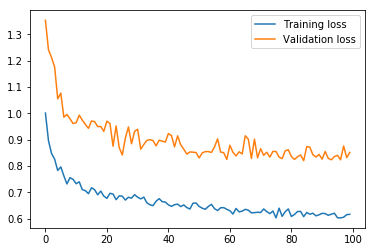

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

## Evaluating the model

We have achieved a good testing accuracy. Now we look at the [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve and [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

AUC for melanoma: 0.7665
AUC for nevus: 0.8387
AUC for seborrheic_keratosis: 0.8910


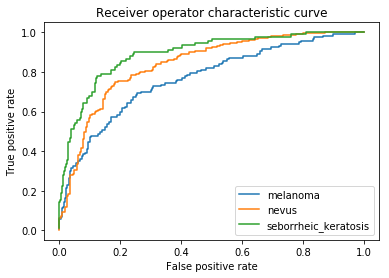

In [15]:
from sklearn.metrics import roc_curve, auc

for i in range(len(diseases)):
    fpr, tpr, _ = roc_curve(test_targets[:,i], model.predict(test_bottleneck)[:,i])
    print('AUC for {}: {:.4f}'.format(diseases[i], auc(fpr, tpr)))
    plt.plot(fpr, tpr, label=diseases[i])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('Receiver operator characteristic curve')
plt.show()

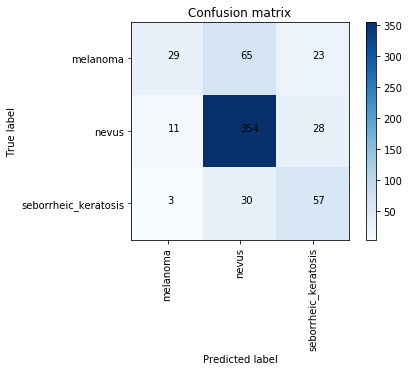

In [16]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(test_targets, axis=1),
                      np.argmax(model.predict(test_bottleneck), axis=1))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
indexes = np.arange(len(diseases))
for i in indexes:
    for j in indexes:
        plt.text(j, i, cm[i, j])
plt.xticks(indexes, diseases, rotation=90)
plt.xlabel('Predicted label')
plt.yticks(indexes, diseases)
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

## Storing predictions in a csv file

As part of this mini-project, we store the predictions in a csv file in order to receive evaluation and scoring.

In [17]:
import csv

with open('predictions.csv', 'w') as f:
    csvwriter = csv.writer(f)
    csvwriter.writerow(['Id', 'task_1', 'task_2'])
    for path in tqdm_notebook(sorted(test_files)):
        tensor = preprocess_input(get_tensor(path))
        pred = model.predict(resnet50.predict(tensor))[0]
        csvwriter.writerow([path, pred[0], pred[2]])

HBox(children=(IntProgress(value=0, max=600), HTML(value='')))

In [32]:
def resnet50_predict(img_path):
    # extract bottleneck features
    bottleneck_feature = path_to_tensor(img_path)
    img = bottleneck_feature.load_img(path, target_size=(1, 1, 2048))
    # obtain predicted vector
    predicted_vector = model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return np.argmax(predicted_vector)

def predict_cancer(img):
    # read the image
    image = cv2.imread(img)
    # convert BGR image to RGB for plotting
    color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # display the image along with bounding box
    plt.imshow(color)
    plt.show()
    
    # predict cancer
    prediction = resnet50_predict(img)
    
predict_cancer(test_files[0])

In [31]:
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

# The End